## Project: Business Metrics Analysis

**Client:** Procrastinate Pro+ - an entertainment application

**Objective:** Identify the reasons for business losses by evaluating the effectiveness of advertising investments and determine new directions for advertising budget allocation.

**Data for Analysis:** Information about users acquired from May 1st to October 27th, 2019, including data on visits, purchases, and advertising expenses.

**Analysis Results:**

- After conducting the analysis, it was revealed that the main issues faced by the company are related to the distribution of the advertising budget. Currently, 80% of the budget is allocated to two advertising sources - TipTop and Faceboom. However, the cost of acquiring customers through these channels is excessively high, leading to unprofitable investments. Additionally, a significant portion of the funds is spent on advertising in the USA, where the return on investment is considerably lower, further exacerbating the company's losses.


- It is recommended to reconsider the distribution of the advertising budget by focusing on sources that show a positive return on investment. This will help reduce expenses on acquiring customers that do not yield desired results. Furthermore, efforts should be strengthened to attract customers from the USA with lower costs and a positive ROI.


- Before making a final decision to abandon the use of TipTop and Faceboom sources, it is advisable to check the settings of the advertising campaigns to rule out the possibility of misidentifying the target audience. If the target audience has been correctly identified, it is recommended to temporarily (e.g., for 6 months) refrain from using these sources. It is possible that the target audience exists, but the cost of attracting them through these sources is too high for the company. In other words, at this stage of the business's development and stability, such expenditures are not affordable.


- When considering the European market, attention should be given to sources with a conversion rate higher than 3% and a positive ROI. It is recommended to distribute the budget evenly among them. Additionally, it is necessary to analyze the reasons for the lack of profitability in the largest user group within the IOS segment (iPhone and Mac). Perhaps the issue is related to the application's settings or interface.


- Overall, reallocating the advertising budget according to the described recommendations will help reduce business losses and enhance the effectiveness of customer acquisition.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

Setting functions for data analysis and processing

In [2]:
def table_info(df):
    """
    The table_info function is designed to check the number and data types of values in a table.

    Arguments:
    - df: pandas.DataFrame - the data table to be checked.

    Returns a pandas.DataFrame containing information about each column of the table:
    - 'name_columns': column names.
    - 'total': total number of non-null values in the column.
    - 'NaN': number of missing values (NaN) in the column.
    - 'types': data type of the column.
    - 'missing_ratio': percentage of missing values relative to the total number of values in the column.

    The resulting DataFrame is sorted by the 'missing_ratio' column in descending order.
    """
    table = pd.DataFrame({
        'total': df.count(),
        'NaN': df.isnull().sum(),
        'types': df.dtypes,
        'missing_ratio': ((df.isnull().sum() / df.shape[0])*100).round(2)})
    table = table.sort_values(by='missing_ratio', ascending=False)  # Sorting by the 'missing_ratio' column in descending order
    table = table.reset_index().rename(columns={'index': 'name_columns'})  # Adding a column with indexes
    return table

Functions for calculating metric values:

- `get_profiles()` - to create user profiles,
- `get_retention()` - to calculate the Retention Rate,
- `get_conversion()` - for conversion calculation,
- `get_ltv()` - to calculate LTV.

Functions for plotting graphs:

- `filter_data()` - for data smoothing,
- `plot_retention()` - to plot the Retention Rate graph,
- `plot_conversion()` - for plotting a conversion graph,
- `plot_ltv_roi` - for visualizing LTV and ROI.

Function to create custom profiles

In [3]:
# Function to create user profiles

def get_profiles(sessions, orders, costs):
    """
    Generates user profiles based on provided data.

    Parameters:
    sessions (DataFrame): DataFrame containing user session data with columns 'user_id', 'session_start', 'channel', 'device', and 'region'.
    orders (DataFrame): DataFrame containing order data with column 'user_id'.
    costs (DataFrame): DataFrame containing advertising costs data with columns 'dt', 'channel', and 'costs'.

    Returns:
    DataFrame: A DataFrame containing user profiles with columns 'user_id', 'first_ts', 'channel', 'device', 'region', 'dt', 'month', 'payer', and 'acquisition_cost'.
    """

    # Find parameters for the first sessions
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # For cohort analysis, determine the date of the first visit
    # and the first day of the month in which the visit occurred
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # Add a flag for paying users
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # Calculate the number of unique users with the same channel and acquisition date
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # Merge advertising costs and the number of acquired users
    costs = costs.merge(new_users, on=['dt', 'channel'], how='left')

    # Divide advertising costs by the number of acquired users
    costs['acquisition_cost'] = costs['costs'] / costs['unique_users']

    # Add the acquisition cost to the profiles
    profiles = profiles.merge(
        costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # The acquisition cost for organic users is set to zero
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

Function to calculate retention

In [4]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # add the payer column to the passed dimensions list
    dimensions = ['payer'] + dimensions

    # exclude users who did not "survive" to the analysis horizon
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # collecting raw data to calculate retention
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # get hold table
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # get a table of retention dynamics
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # return both tables and raw data
    return result_raw, result_grouped, result_in_time

Function for calculating conversion

In [5]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # exclude users who did not "survive" to the analysis horizon
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # determine the date and time of the first purchase for each user
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # add purchase data to profiles
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # calculate lifetime for each purchase
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # group by cohort if there is nothing in dimensions
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # function for grouping the table according to the desired features
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # divide each "cell" in the row by the size of the cohort
        # and get the conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # get the conversion table
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # remove 'cohort' from dimensions for the conversion dynamics table
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # return both tables and raw data
    return result_raw, result_grouped, result_in_time

Function for calculating LTV and ROI

In [6]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):
    """
    Calculate Lifetime Value (LTV) and Return on Investment (ROI) for user cohorts and over time.

    Parameters:
    profiles (DataFrame): DataFrame containing user profiles with columns 'user_id', 'first_ts', 'channel', 'device', 'region', 'dt', 'month', 'payer', and 'acquisition_cost'.
    purchases (DataFrame): DataFrame containing purchase data with columns 'user_id', 'event_dt', and 'revenue'.
    observation_date (datetime): The date of observation or analysis start.
    horizon_days (int): The number of days for the analysis horizon.
    dimensions (list, optional): A list of additional dimensions to group data (e.g., ['region', 'device']). Default is an empty list.
    ignore_horizon (bool, optional): If True, it ignores the horizon days and considers all users. Default is False.

    Returns:
    Tuple: A tuple containing the following DataFrames:
        result_raw (DataFrame): Raw data with user profiles and purchase information.
        result_grouped (DataFrame): LTV table grouped by cohorts and additional dimensions.
        result_in_time (DataFrame): LTV dynamics table over time for cohorts and additional dimensions.
        roi_grouped (DataFrame): ROI table grouped by cohorts and additional dimensions.
        roi_in_time (DataFrame): ROI dynamics table over time for cohorts and additional dimensions.
    """

    # Excludes users who did not reach the analysis horizon
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # Adds purchase data to user profiles
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )

    # Calculate user lifetime for each purchase
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # Group by cohort if there are no additional dimensions specified
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # Function for grouping by desired dimensions
    def group_by_dimensions(df, dims, horizon_days):
        # Build a "triangle" revenue table
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )

        # Calculate cumulative revenue
        result = result.fillna(0).cumsum(axis=1)

        # Calculate cohort sizes
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )

        # Merge cohort sizes with revenue table
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)

        # Calculate LTV: divide each cell in the row by the cohort size
        result = result.div(result['cohort_size'], axis=0)

        # Exclude all lifetimes that exceed the analysis horizon
        result = result[['cohort_size'] + list(range(horizon_days))]

        # Restore cohort sizes
        result['cohort_size'] = cohort_sizes

        # Build DataFrame with user data and CAC values, adding dimensions parameters
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # Calculate the average CAC based on the dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # Calculate ROI: divide LTV by CAC
        roi = result.div(cac['cac'], axis=0)

        # Remove rows with infinite ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # Restore cohort sizes in the ROI table
        roi['cohort_size'] = cohort_sizes

        # Add CAC to the ROI table
        roi['cac'] = cac['cac']

        # Keep only cohort sizes, CAC, and ROI values within the analysis horizon
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # Return LTV and ROI tables
        return result, roi

    # Get LTV and ROI tables
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # Remove 'cohort' from dimensions for the LTV and ROI dynamics tables
    if 'cohort' in dimensions:
        dimensions = []

    # Get LTV and ROI dynamics tables
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,          # Raw data
        result_grouped,      # LTV table
        result_in_time,      # LTV dynamics table
        roi_grouped,         # ROI table
        roi_in_time,         # ROI dynamics table
    )

In [7]:
# function to smooth the frame

def filter_data(df, window):
   # apply a moving average for each column
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

Function to visualize retention

In [8]:
def plot_retention(retention, retention_history, horizon, window=7):

    plt.figure(figsize=(15, 10))

    # exclude cohort sizes and first day retention
    retention = retention.drop(columns=['cohort_size', 0])
    # leave only the desired lifetime in the dynamics table
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

     # if there is only payer in the indexes of the hold table,
     # add the second feature - cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

     # in the graph table - two columns and two rows, four cells
     # in the first we build retention curves for paying users
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('Retention of paying users')

     # in the second cell we build non-paying retention curves
     # vertical axis - from the graph from the first cell
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('Retention of non-paying users')

    # in the third cell - the dynamics of retention of paying
    ax3 = plt.subplot(2, 2, 3)
    # get the column names for the pivot table
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # filter data and plot
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Engagement date')
    plt.title(
        'Dynamics of retention of paying users on the {}-th day'.format(
            horizon
        )
    )

    # in the fourth cell - the dynamics of retention of non-paying
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # filter data and plot
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Engagement date')
    plt.title(
        'Dynamics of retention of non-paying users on the {}-th day'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

Function to visualize the conversion

In [9]:
def plot_conversion(conversion, conversion_history, horizon, window=7):
    """
    Plots conversion curves and dynamics for user cohorts.

    Parameters:
    conversion (DataFrame): DataFrame containing conversion data with columns representing user lifetimes.
    conversion_history (DataFrame): DataFrame containing conversion dynamics data with columns representing days since acquisition.
    horizon (int): The day for which the conversion dynamics will be plotted.
    window (int, optional): The window size for the moving average of the conversion dynamics plot. Default is 7.

    Returns:
    None
    """

    # Set the grid size for the plots
    plt.figure(figsize=(15, 5))

    # Exclude cohort sizes
    conversion = conversion.drop(columns=['cohort_size'])

    # Keep only the specified lifetime in the conversion dynamics table
    conversion_history = conversion_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # First plot - conversion curves
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('User Conversion')

    # Second plot - conversion dynamics
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # The columns of the pivot table will be all index columns except the date
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Acquisition Date')
    plt.title('User Conversion Dynamics on Day {}'.format(horizon))

    plt.tight_layout()
    plt.show()

Function for visualizing LTV, ROI

In [10]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    plt.figure(figsize=(20, 10))

    # exclude cohort sizes from table ltv
    ltv = ltv.drop(columns=['cohort_size'])
    # leave only the desired lifetime in the ltv dynamics table
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # write the cost of attraction in a separate frame
    cac_history = roi_history[['cac']]

    # exclude cohort sizes and cac from table roi
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # leave only the desired lifetime in the roi dynamics table
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # first graph - ltv curves
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('LTV')

    # second graph - ltv dynamics
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Customer Acquisition Time')
    plt.title('User LTV dynamics on the {} day'.format(horizon))

    # the third graph is the dynamics of cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # all index columns except date will become pivot table columns
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Customer Acquisition Time')
    plt.title('User Acquisition Cost Dynamics')

    # fourth graph - roi curves
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Payback level')
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('ROI')

    # the fifth graph is the dynamics of roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # all index columns except date will become pivot table columns
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Payback level')
    plt.xlabel('Customer Acquisition Time')
    plt.title('Dynamics of ROI of users on the {}-th day'.format(horizon))

    plt.tight_layout()
    plt.show()

Loading data

In [11]:
visits, orders, costs = (
    pd.read_csv('/Users/yuliamazur/ПИТОН/ПРОЕКТЫ/visits_info_short.csv'),  
    pd.read_csv('/Users/yuliamazur/ПИТОН/ПРОЕКТЫ/orders_info_short.csv'),  
    pd.read_csv('/Users/yuliamazur/ПИТОН/ПРОЕКТЫ/costs_info_short.csv'),  
)

print('visits')
display(visits.head())
print()
print('orders')
display(orders.head())
print()
print('costs')
display(costs.head())

visits


,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40



orders


,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99



costs


,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


**Data Description**


**visits_info_short.csv:**
- `User Id` - unique user ID,
- `Region` — user's country,
- `Device` — user device type,
- `Channe`l - transition source ID,
- `Session Start` — date and time of session start,
- `Session End` — date and time of the end of the session.


**orders_info_short.csv:**
- `User Id` - unique user ID,
- `Event Dt` - date and time of purchase,
- `Revenue` — order amount.


**costs_info_short.csv:**
- `dt` — date of the advertising campaign,
- `Channel` — advertising source identifier,
- `costs` - costs for this campaign.

Let's bring the names of the columns in all tables to lower case and a single format. Check for duplicates and omissions.

In [12]:
visits, orders, costs = map(lambda df: df.rename(columns=str.lower), [visits, orders, costs])

In [13]:
visits = visits.rename(columns = {'user id':'user_id', 'session start':'session_start', 'session end':'session_end'})
orders = orders.rename(columns = {'user id':'user_id', 'event dt':'event_dt'})

In [14]:
print('Number of duplicates in visits, orders, costs:',
      sum(map(lambda df: df.duplicated().sum(), [visits, orders, costs])))

Number of duplicates in visits, orders, costs: 0


In [15]:
print('Number of missing values in visits, orders, costs:',
      sum(map(lambda df: df.isna().sum().sum(), [visits, orders, costs])))

Number of missing values in visits, orders, costs: 0


Let's see what are the unique values of the columns with regions, devices and channels.

In [16]:
temp = visits.copy() 
temp_list = ['region', 'device', 'channel']

for colum in temp_list:
    print(colum, temp[colum].sort_values().unique())

region ['France' 'Germany' 'UK' 'United States']
device ['Android' 'Mac' 'PC' 'iPhone']
channel ['AdNonSense' 'FaceBoom' 'LeapBob' 'MediaTornado' 'OppleCreativeMedia'
 'RocketSuperAds' 'TipTop' 'WahooNetBanner' 'YRabbit' 'lambdaMediaAds'
 'organic']


Сheck the data types, bring to the required format.

In [17]:
table_info(visits)

,name_columns,total,NaN,types,missing_ratio
0,user_id,309901,0,int64,0.0
1,region,309901,0,object,0.0
2,device,309901,0,object,0.0
3,channel,309901,0,object,0.0
4,session_start,309901,0,object,0.0
5,session_end,309901,0,object,0.0


In [18]:
table_info(orders)

,name_columns,total,NaN,types,missing_ratio
0,user_id,40212,0,int64,0.0
1,event_dt,40212,0,object,0.0
2,revenue,40212,0,float64,0.0


In [19]:
table_info(costs)

,name_columns,total,NaN,types,missing_ratio
0,dt,1800,0,object,0.0
1,channel,1800,0,object,0.0
2,costs,1800,0,float64,0.0


Let's convert the columns from time to the appropriate format. There are no gaps in the tables.

In [20]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date 

### Exploratory data analysis

- Compiling user profiles. We determine the minimum and maximum dates for attracting users.

- We find out from which countries users come to the application and which country has the most paying users. We build a table reflecting the number of users and the share of paying from each country.

- Find out what devices customers use and what devices paying users prefer. We build a table that reflects the number of users and the share of paying for each device.

- We study advertising sources of attraction and determine the channels from which the most paying users came. We build a table that reflects the number of users and the share of paying for each acquisition channel.

In [21]:
profiles = get_profiles(visits, orders, costs)
print(profiles.head(5))

    user_id            first_ts     channel  device         region  \
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States   
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States   

           dt      month  payer  acquisition_cost  
0  2019-05-07 2019-05-01   True          1.088172  
1  2019-07-09 2019-07-01  False          1.107237  
2  2019-10-01 2019-10-01  False          0.000000  
3  2019-08-22 2019-08-01  False          0.988235  
4  2019-10-02 2019-10-01  False          0.230769  


In [22]:
min_analysis_date = profiles['dt'].min()
max_analysis_date = profiles['dt'].max()
observation_date = datetime(2019, 11, 1).date()

print(min_analysis_date, observation_date)

horizon_days = 14
max_analysis_date = observation_date - timedelta(days=horizon_days - 1)
print(max_analysis_date)

2019-05-01 2019-11-01
2019-10-19


In [23]:
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


Let's find out from which countries users come to the application and which country has the most paying users. Let's build a table that reflects the number of users and the share of paying from each country. Let's write a function to create tables according to different criteria of the profiles table.

In [24]:
def get_details(
    profiles,
    dimensions=[]
):
    profiles_details = profiles.pivot_table(index = dimensions, columns = 'payer', values = 'user_id', aggfunc = 'count').rename(columns={False: 'not_payer', True: 'payer'})
    profiles_details['total_users'] = profiles.groupby(dimensions).agg({'user_id':'count'})
    profiles_details['part_of_payers'] = (profiles_details['payer'] / profiles_details['total_users'] *100).round(2)
    sorted_profiles_details = profiles_details.sort_values(by='part_of_payers', ascending = False)
    return sorted_profiles_details

In [25]:
sorted_profiles_details = get_details(profiles, dimensions=['region'])
sorted_profiles_details

payer,not_payer,payer,total_users,part_of_payers
region,,,,
United States,93100,6902,100002,6.90
Germany,14365,616,14981,4.11
UK,16875,700,17575,3.98
France,16787,663,17450,3.80


`Notes`

Central Asia in terms of regions of use can be divided into 2 segments: the USA and Europe

- `USA` - the leader in terms of the number of users and the share of paying users.

- `Europe` - England, France are approximately in the same range of values ​​both in terms of the number of users and the share of paying users. Germany lags behind in terms of the number of users and is in last place, but the share of paying people is higher than in England and France.

Find out what devices customers use and what devices paying users prefer. Let's build a table showing the number of users and share of paying for each device.

In [26]:
sorted_profiles_details = get_details(profiles, dimensions=['device'])
sorted_profiles_details

payer,not_payer,payer,total_users,part_of_payers
device,,,,
Mac,28130,1912,30042,6.36
iPhone,51097,3382,54479,6.21
Android,32982,2050,35032,5.85
PC,28918,1537,30455,5.05


`Notes`

The share of paying users is higher for those who use the IOS system, be it iPhone or Mac.
Despite the fact that the total number of PC and MAC users is almost the same, the share of "paying" users of MAC is much higher.

Let's look at the advertising sources of attraction and determine the channels from which the most paying users came. Let's build a table that reflects the number of users and the share of paying for each acquisition channel.

In [27]:
sorted_profiles_details = get_details(profiles, dimensions=['channel'])
sorted_profiles_details

payer,not_payer,payer,total_users,part_of_payers
channel,,,,
FaceBoom,25587,3557,29144,12.20
AdNonSense,3440,440,3880,11.34
lambdaMediaAds,1924,225,2149,10.47
TipTop,17683,1878,19561,9.60
RocketSuperAds,4096,352,4448,7.91
WahooNetBanner,8100,453,8553,5.30
YRabbit,4147,165,4312,3.83
MediaTornado,4208,156,4364,3.57
LeapBob,8291,262,8553,3.06


`Notes` 

In terms of the total number of users, "organics" are in the lead, but the share of paying users in this group is traditionally low.
The best indicators for the share of paying - FaceBoom, AdNonSense, lambdaMediaAds. And if FaceBoom has the best indicators in terms of the total number of users after organics, then AdNonSense and lambdaMediaAds, on the contrary, have the least users. So in absolute terms, this high conversion gives small numbers.

TipTop has interesting indicators - there are a lot of users, and the conversion for such numbers is low. We have to find out the reasons for these values. It's too early to draw conclusions.

### Marketing

- Calculate the total cost of marketing.
- We find out how spending is distributed among advertising sources, that is, how much money was spent on each source.
- We build a visualization of the dynamics of changes in expenses over time (by weeks and months) for each source.
- Find out how much it cost on average to attract one user (CAC) from each source.

In [28]:
costs.pivot_table(index='channel', values='costs', aggfunc='sum', margins=True)\
.round().sort_values(by='costs', ascending=False)

,costs
channel,
All,105497.0
TipTop,54751.0
FaceBoom,32446.0
WahooNetBanner,5151.0
AdNonSense,3911.0
OppleCreativeMedia,2151.0
RocketSuperAds,1833.0
LeapBob,1798.0
lambdaMediaAds,1558.0


`Notes` 

Total advertising expenses - 105,497.

There are two promotion channels in terms of the amount of invested funds, which were obviously given priority: TipTop and FaceBoom, and this is about 80% of the total budget for this period. The remaining sources are funded on a residual basis and the amount of costs for them is at least 6 times less than on TipTop or FaceBoom.

### Graph of the dynamics of changes in spending over time by source

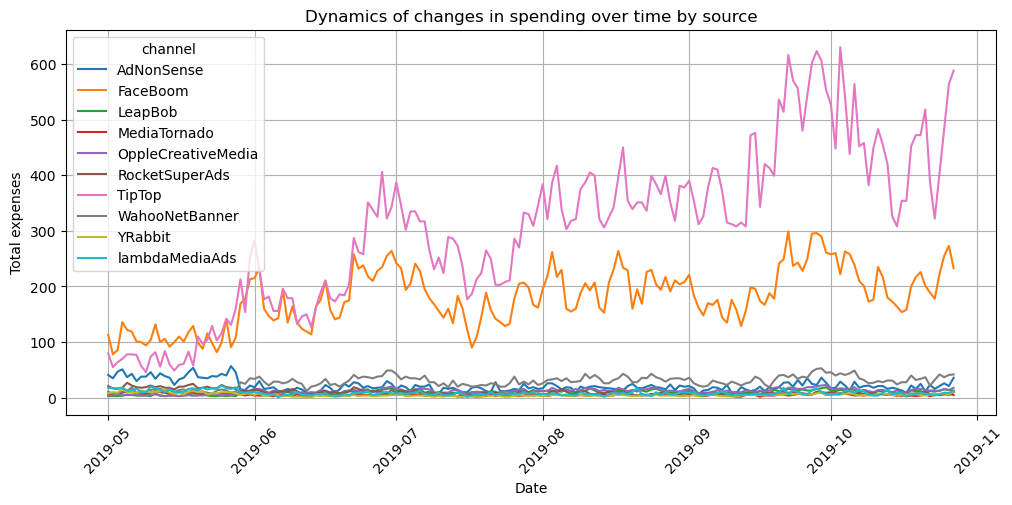

In [29]:
costs.pivot_table(index='dt', columns='channel', values='costs', aggfunc='sum')\
.round().plot(grid=True, figsize=(12, 5))

plt.title('Dynamics of changes in spending over time by source')
plt.xlabel('Date')
plt.xticks(rotation = 45)
plt.ylabel('Total expenses')
plt.show()

We will build graphs separately for weeks and months.

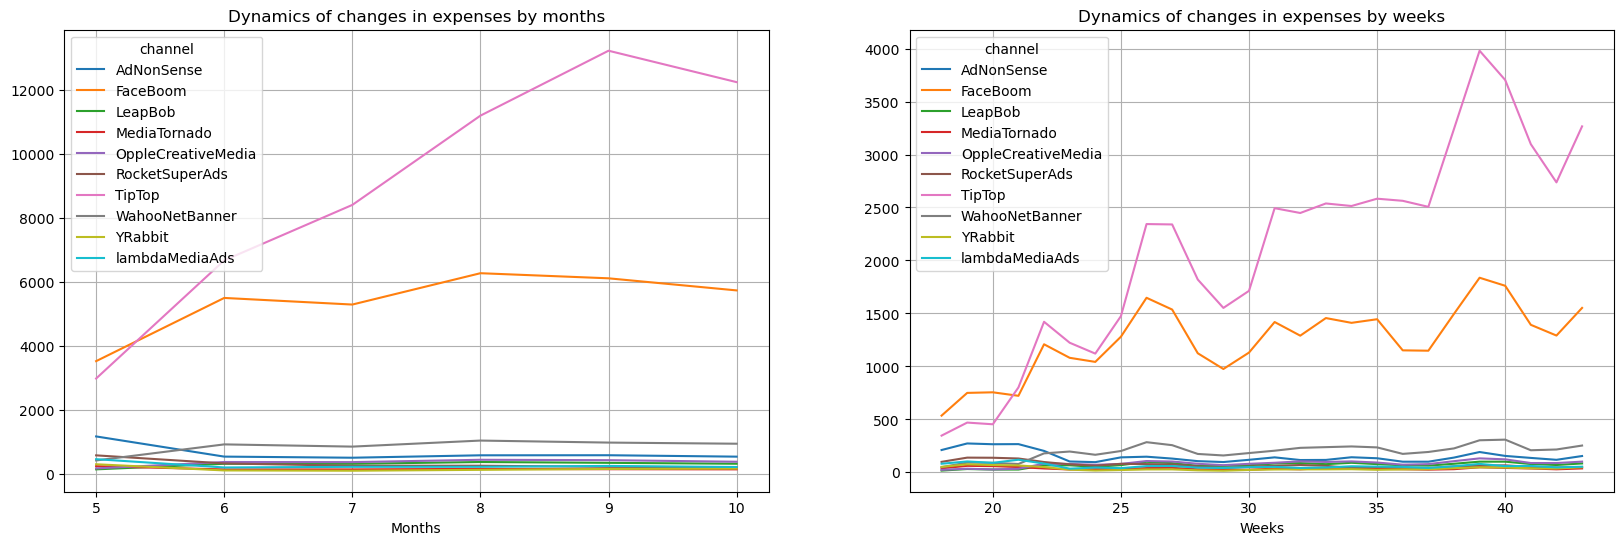

In [30]:
plt.figure(figsize = (20, 6))
costs['dt'] = pd.to_datetime(costs['dt'])
costs['week'] = costs['dt'].dt.isocalendar().week
costs['dt_month'] = costs['dt'].dt.month

costs.pivot_table(
    index='dt_month', columns='channel', values='costs', aggfunc='sum'
).plot(grid=True, ax=plt.subplot(1, 2, 1))
plt.title('Dynamics of changes in expenses by months')
plt.xlabel('Months')

costs.pivot_table(
    index='week', columns='channel', values='costs', aggfunc='sum'
).plot(grid=True, ax=plt.subplot(1, 2, 2)) 
plt.title('Dynamics of changes in expenses by weeks')
plt.xlabel('Weeks')

plt.show()


`Notes` 

A sharp increase in investments in two sources TipTop and FaceBoom is noticeable. It starts in June, although in May these sources also received the most from the advertising budget. Also in May, the source of AdNonSense is noticeable, but since June the picture has changed. Only two sources began to receive 80% of the budget.

Let's find out how much it cost on average to attract one user (CAC) from each source.

In [31]:
channel_cac = (profiles.query('channel != "organic"')
       .pivot_table(index = 'channel',
                    values = 'acquisition_cost',
                    aggfunc='mean')
       .sort_values(by='acquisition_cost', ascending=False)
       .rename(columns={'acquisition_cost': 'cac'})
      )
channel_cac

,cac
channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717


`Notes`: the most expensive acquisition channel is TipTop. FaceBoom is almost three times cheaper than TipTop. TipTop takes a lot of budget, the cost is prohibitive, and the return seems very doubtful so far. Let's check this further. Let's look at the average CAC value across all channels.

In [32]:
mean_cac = round(profiles['acquisition_cost'].mean(), 2)
mean_cac

0.7

The average cost of attraction is 1.13. Since the cost of TipTop is significantly higher than all other channels, the average value is high, so 9 out of 10 sources have a cost below the average. Let's also see how many advertising campaigns were carried out for the two most expensive sources.

In [33]:
face = round((profiles['channel'] == 'FaceBoom').mean()*100)
tip = round((profiles['channel'] == 'TipTop').mean()*100)
print(f"Share of advertising campaigns for FaceBoom: {face}%")
print(f"Share of advertising campaigns for TipTop: {tip}%")

Share of advertising campaigns for FaceBoom: 19%
Share of advertising campaigns for TipTop: 13%


More than 50% of advertising campaigns were organized in two sources out of 10. The advertising budget was allocated with priority to these channels.

### Advertising ROI estimate

Using LTV, ROI and CAC charts, let's analyze the payback of advertising. We believe that November 1, 2019 is on the calendar, and the business plan stipulates that users should pay off no later than two weeks after attracting.

- We analyze the payback of advertising using LTV and ROI charts, as well as charts of LTV, CAC and ROI dynamics.
- We check the conversion of users and the dynamics of its change. We will do the same with user retention.
- We analyze the payback of advertising by device. We build LTV and ROI charts, as well as charts of LTV, CAC and ROI dynamics.
- We analyze the payback of advertising by country. We build LTV and ROI charts, as well as charts of LTV, CAC and ROI dynamics.
- We analyze the payback of advertising with a breakdown by advertising channels. We build LTV and ROI charts, as well as charts of LTV, CAC and ROI dynamics.
- Answering questions:
     - Does advertising aimed at attracting users in general pay off?
     - What devices, countries and advertising channels can have a negative impact on advertising ROI?
     - What can cause payback problems?

Let's exclude organic users from the analysis. Their segment is very extensive in terms of the total number of users. This can distort the charts.

In [34]:
profiles = profiles.query('channel != "organic"')

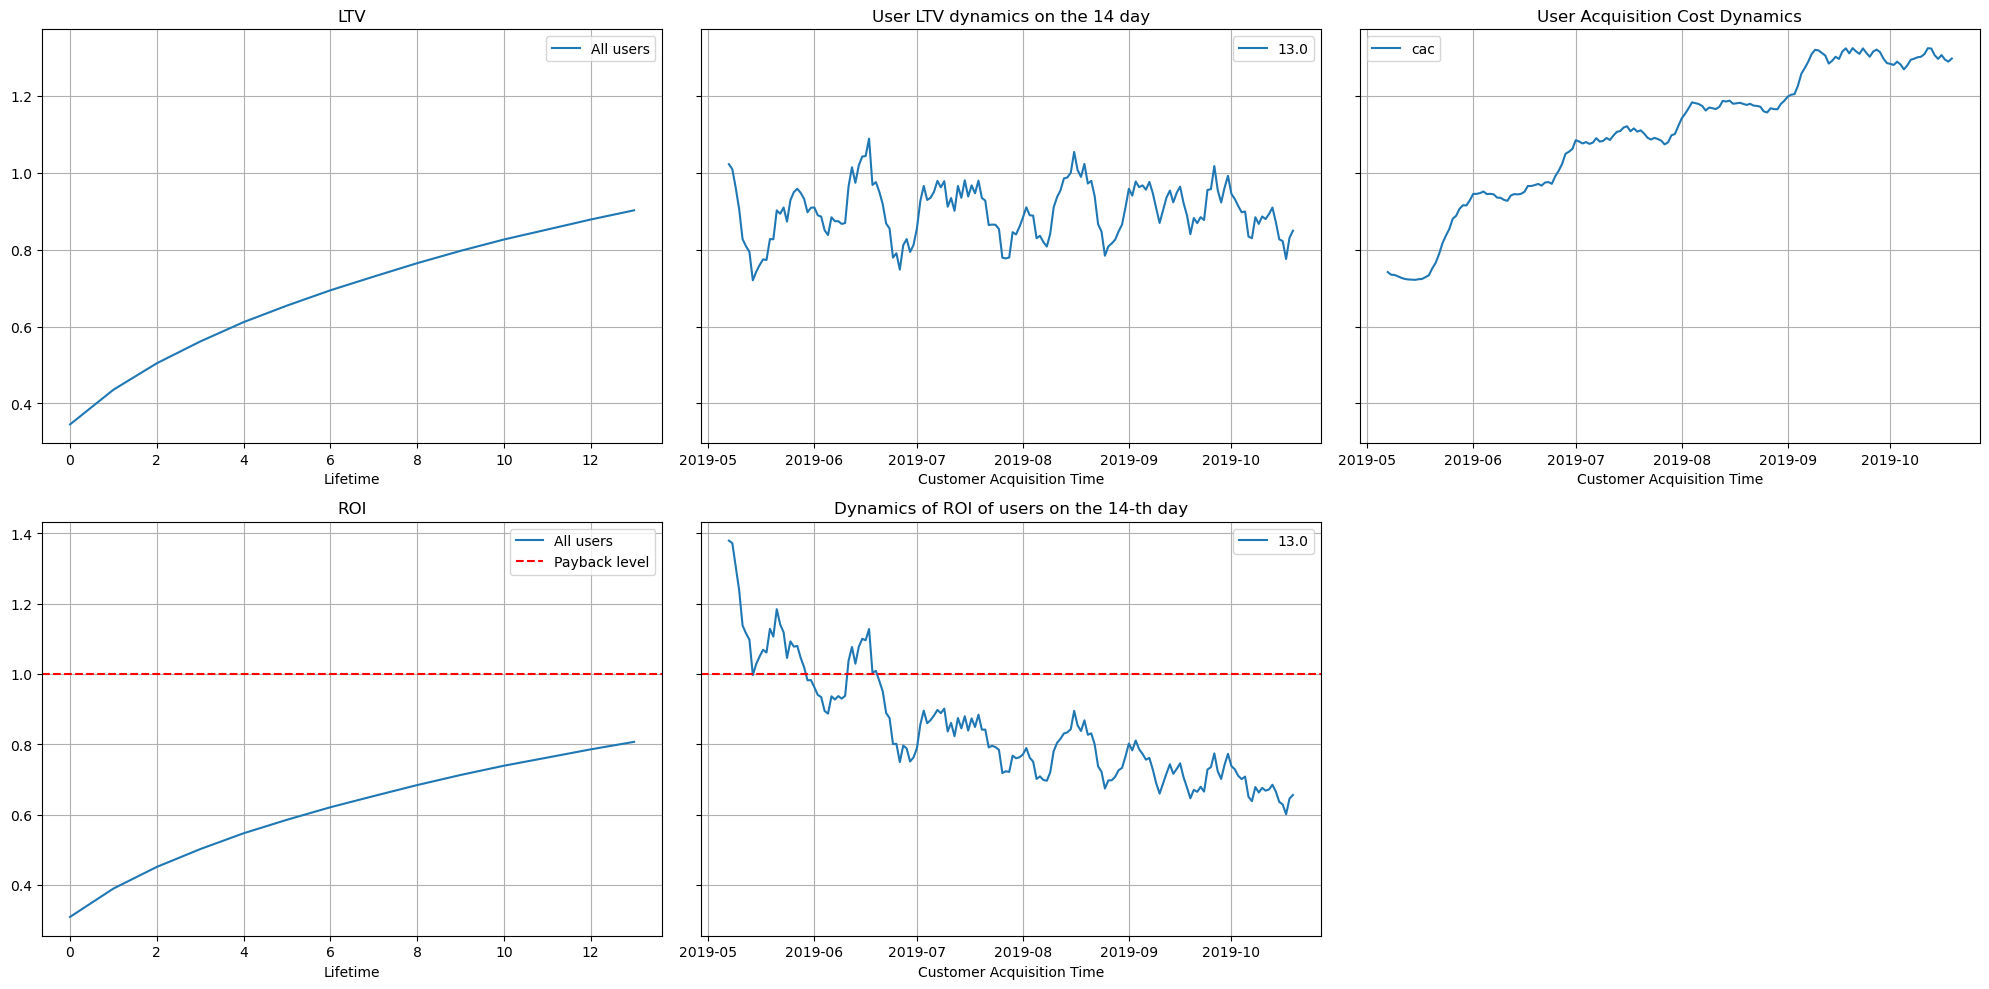

In [35]:
# calculate LTV and ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

`Notes`:
- Advertising does not pay off. ROI at the end of the week is slightly above 80%.
- САС shows growth dynamics starting from mid-May. The cost of attraction by October compared to May increased by about two times. This is reflected in ROI. The acquisition budget has also increased.
- LTV is affected by various factors, but even this indicator even slightly improved by November, compared to May. The swing range has been reduced.
- ROI broken down by day 14 shows that in May, investments in advertising were still paying off, but then a protracted decline began. Let's see how the advertising budget was distributed. He grew up, but did not bring the desired money from buyers.

We check the conversion of users and the dynamics of its change. We will do the same with user retention. We will build and study conversion and retention charts.

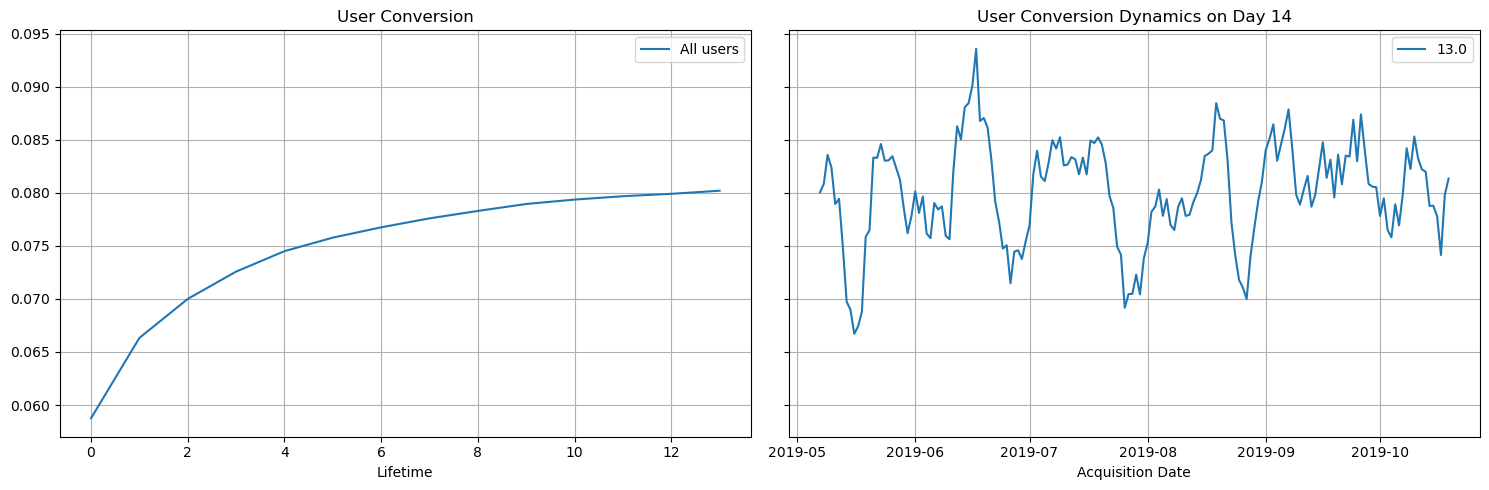

In [36]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

`Notes`:
- Conversion increases by day 14. This is fine. And remains at about 80%.
- The dynamics of conversion changes from sharp rises to sharp falls.

**Conversion by channels.**

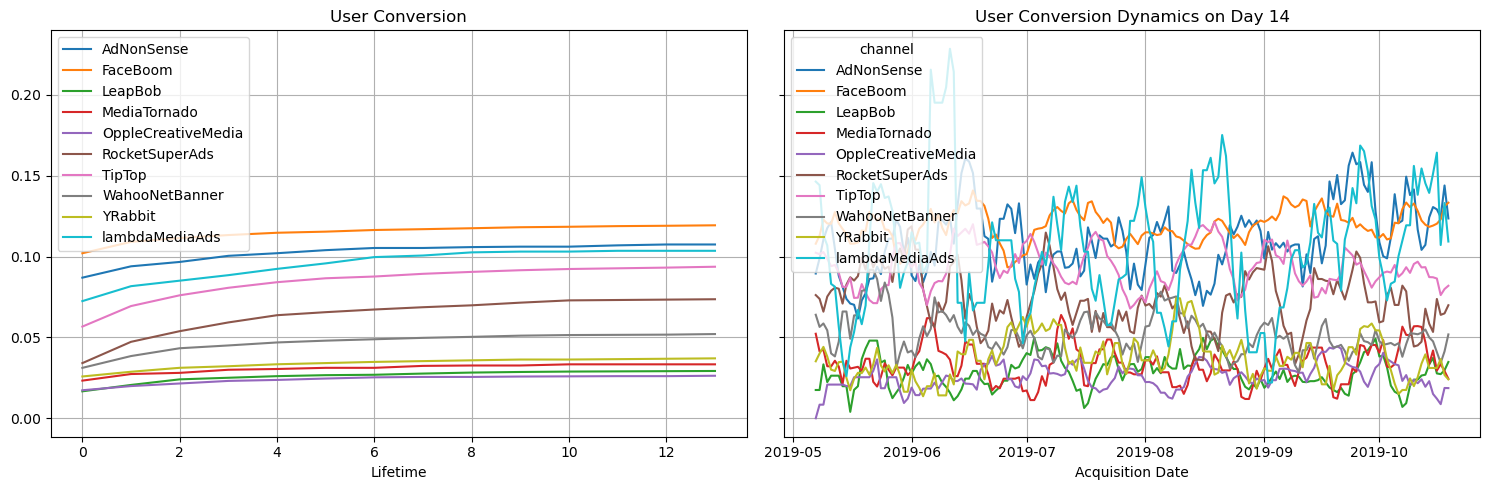

In [37]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['channel']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

`Notes:`
- Conversion for all channels looks bad. Too "flat". There is no significant rise towards the end of lifetime.
- The graph of the conversion dynamics is not informative in this form, fluctuations from zero to 15%. In June and August, one source came out ahead - LambdaMediaAds.

**Conversion by region.**

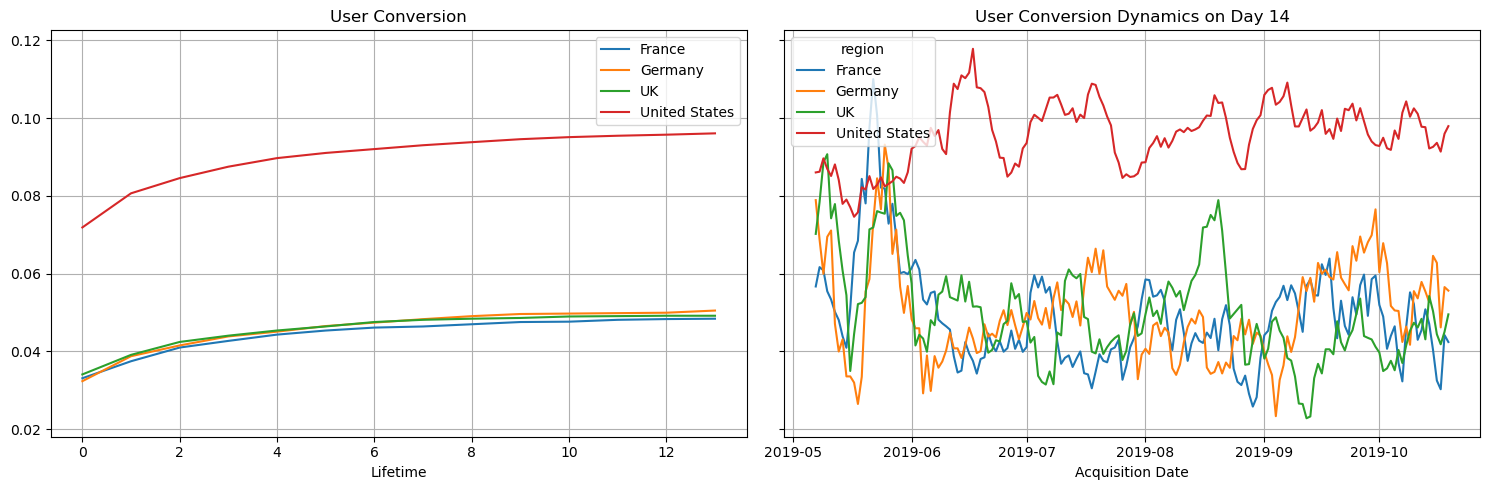

In [38]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['region']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

`Notes`:
- The USA is the leader in terms of conversion and its dynamics. However, the high acquisition cost in this region offsets the value of the conversion.
- Europe sticks together. After June, the metric dropped noticeably, just during this period, active budget injections into the United States began, which led to the fact that the United States occupies the top bar.

**Conversion by device.**

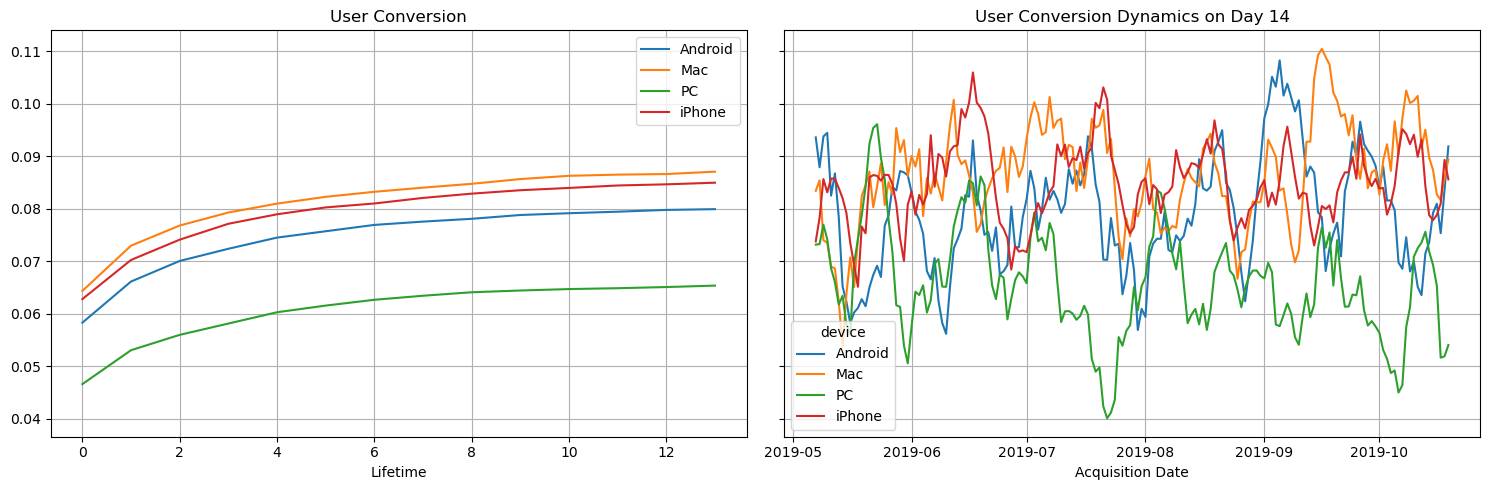

In [39]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['device']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

`Notes`:
- Apple leads in conversions. PC is last. Next, we will evaluate the payback of these devices. It's too early to draw conclusions.
- In the dynamics of the fluctuation, you can see that the RS stands out. In August, RS has a sharp drop.

**Retention calculation**

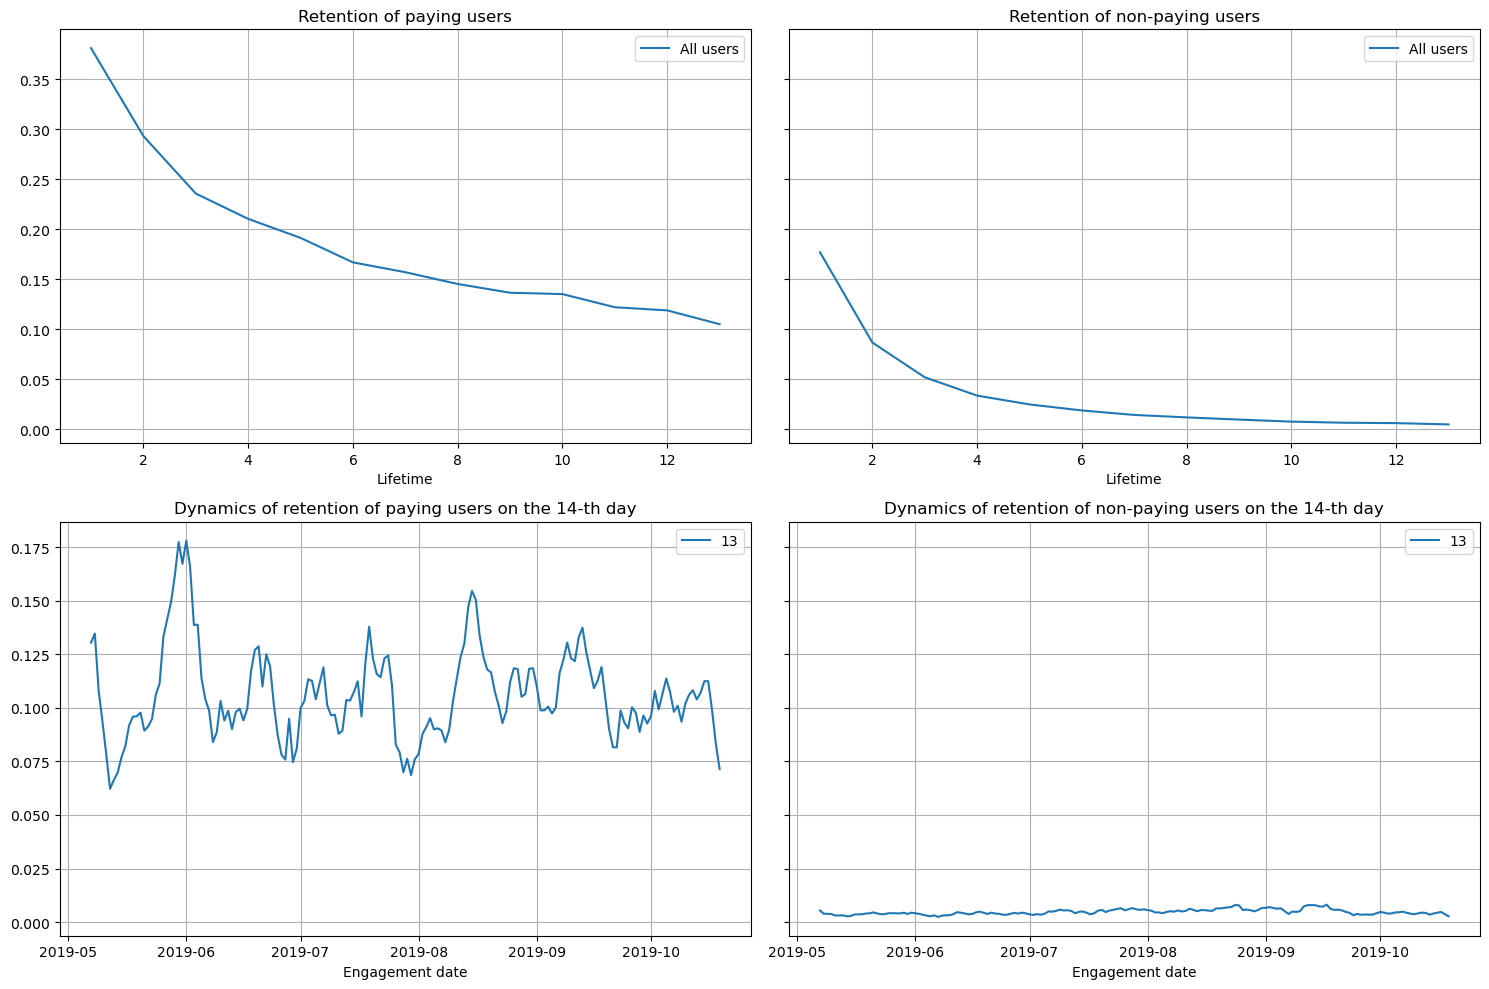

In [40]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days
)

plot_retention(retention_grouped, retention_history, horizon_days)

`Notes`:
- Retention of non-payers and their dynamics are reflected almost traditionally for this group of users. Retention gradually decreases by day 14 and smoothly among months.
- Retention of paying users at first glance looks normal, however, sharp peaks and falls are noticeable on the chart of retention dynamics by months.

Let's look at retention metrics by channel, region, and device.

**Retention in the context of channels.**

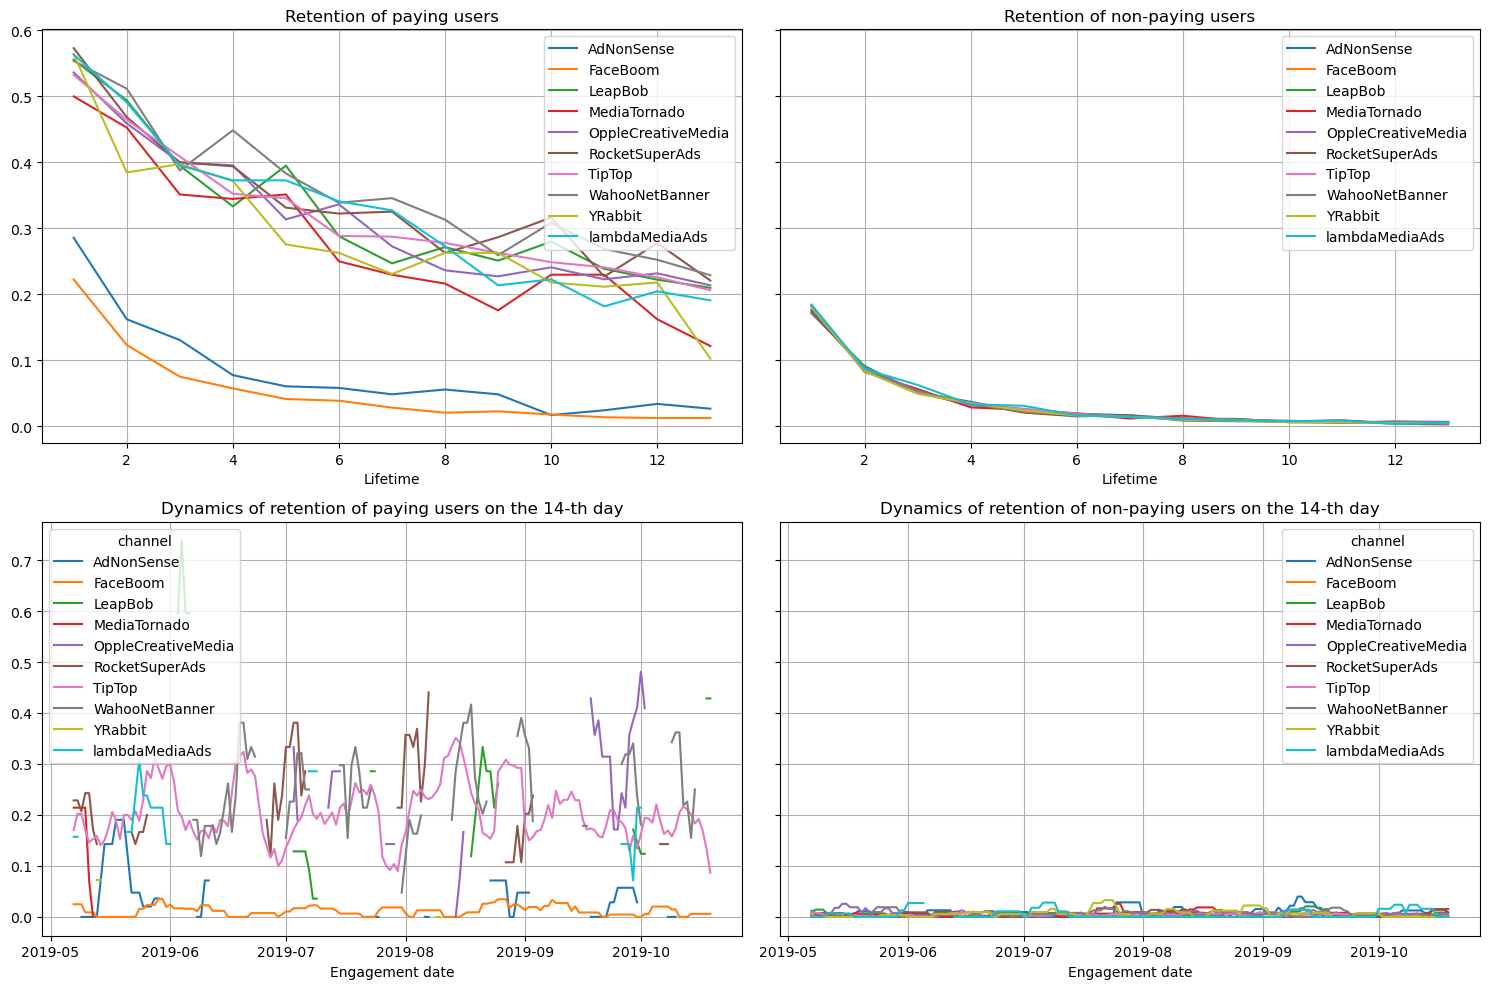

In [41]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['channel']
)

plot_retention(retention_grouped, retention_history, horizon_days)

`Notes`:
- Two outsiders stand out on the retention chart, FaceBoom and AndNonSense. Given that FaceBoom accounted for more than 30% of all advertising campaigns in a given period, it is clear that this source is dragging down the acceptable retention rates of all other sources.
- For non-spitting users, expected values, start lifetime at 20%.
- It is important that FaceBoom and AndNonSense start in lifetime close to non-paying users.

**Retention by regions.**

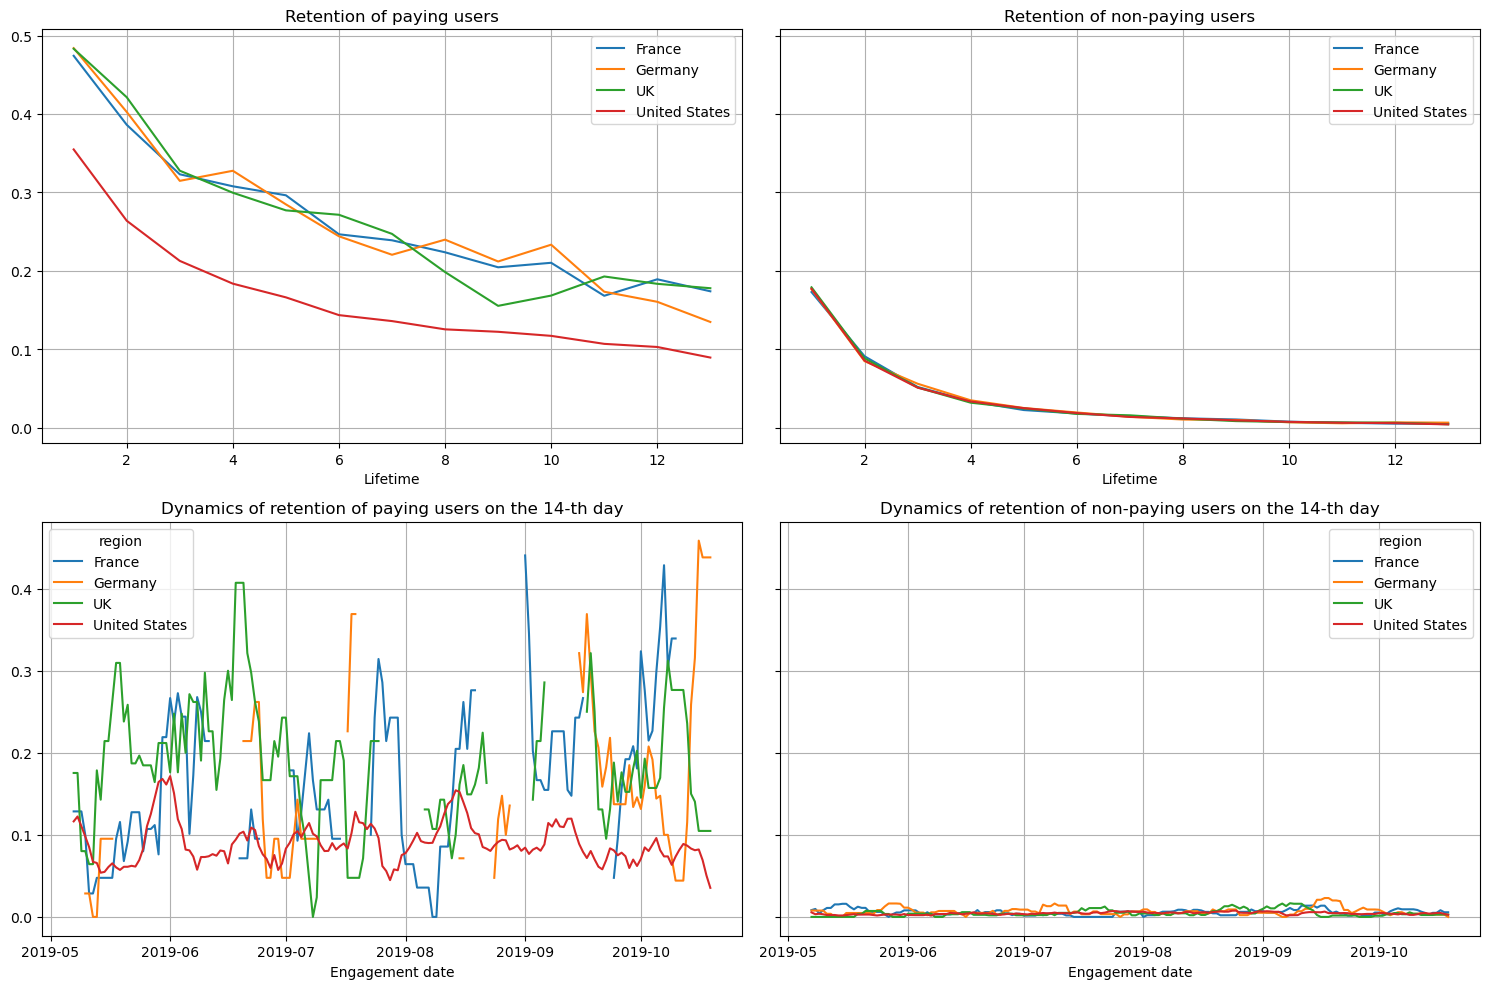

In [42]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['region']
)

plot_retention(retention_grouped, retention_history, horizon_days)

`Notes`:
- The United States is in last place in terms of retention and by a significant margin from Europe. There must obviously be a reason here, as an option - the quality and nature of the target audience. Perhaps it was chosen incorrectly.
- For non-paying users, the performance is expected.
- The dynamics of retaining Europe is very unstable, but the United States is almost stable, but only this stability does not help, everything is in the "minus".

**Retention in the context of devices.**

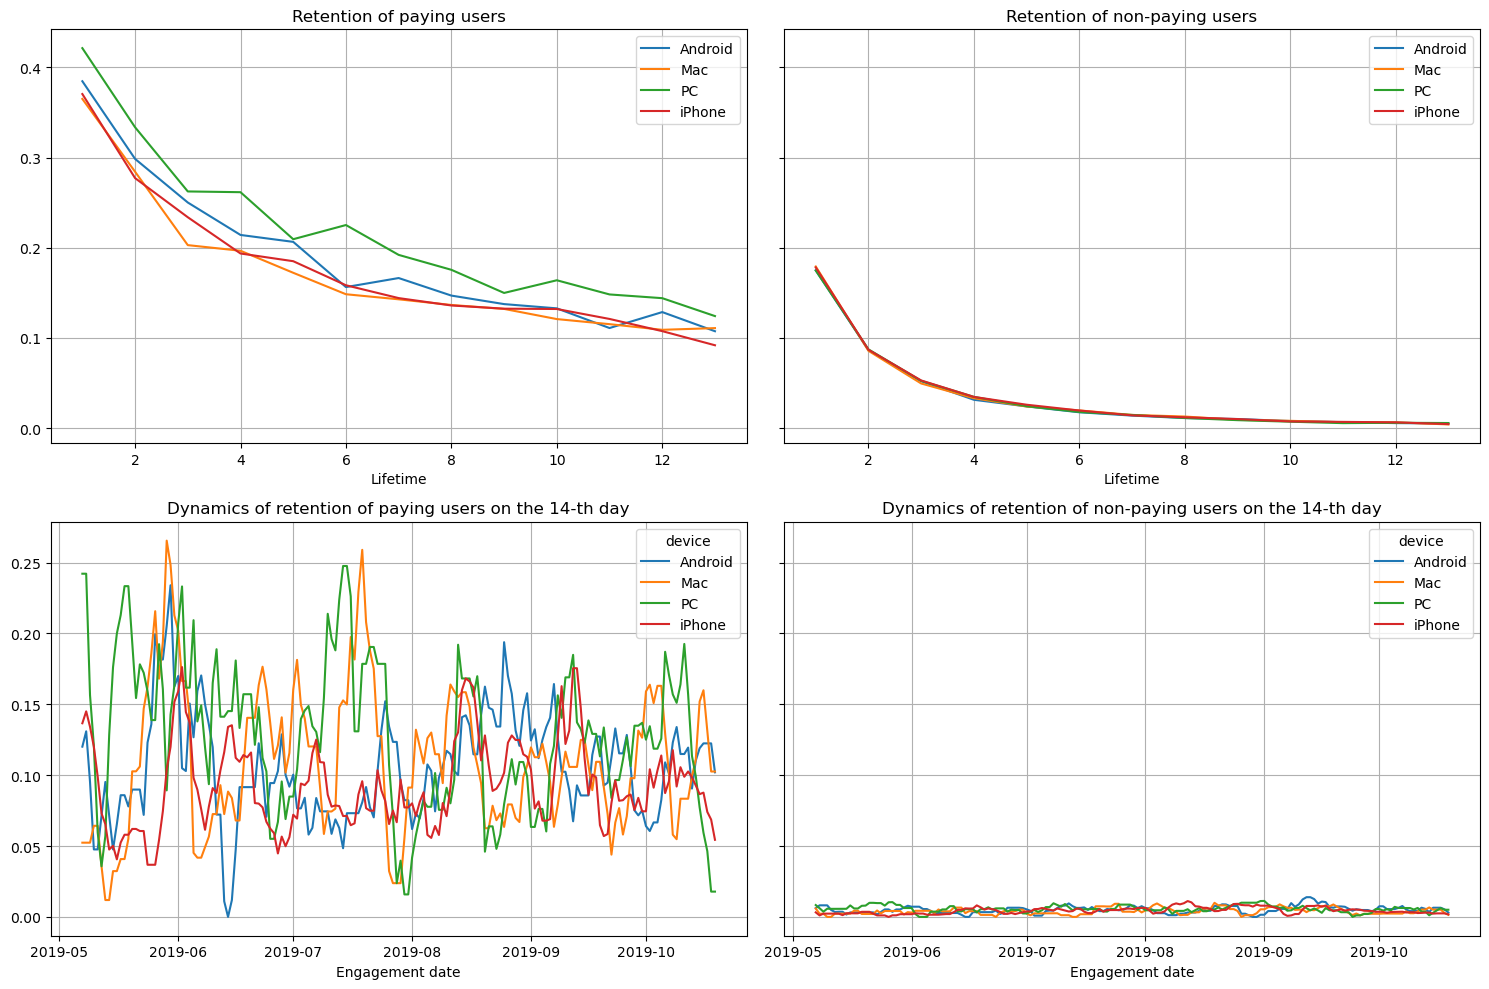

In [43]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['device']
)

plot_retention(retention_grouped, retention_history, horizon_days)

`Notes`:
- Hold better show PC and Android. And this is despite the fact that we previously found that the number of users is greater among those who prefer IOS. However, it is these devices that lead the company to a "minus"
- For non-paying users, the situation is predictable, does not raise questions, except for one. The retention of the first day is only two times less than that of the paying ones.

### Analysis of advertising ROI by device.

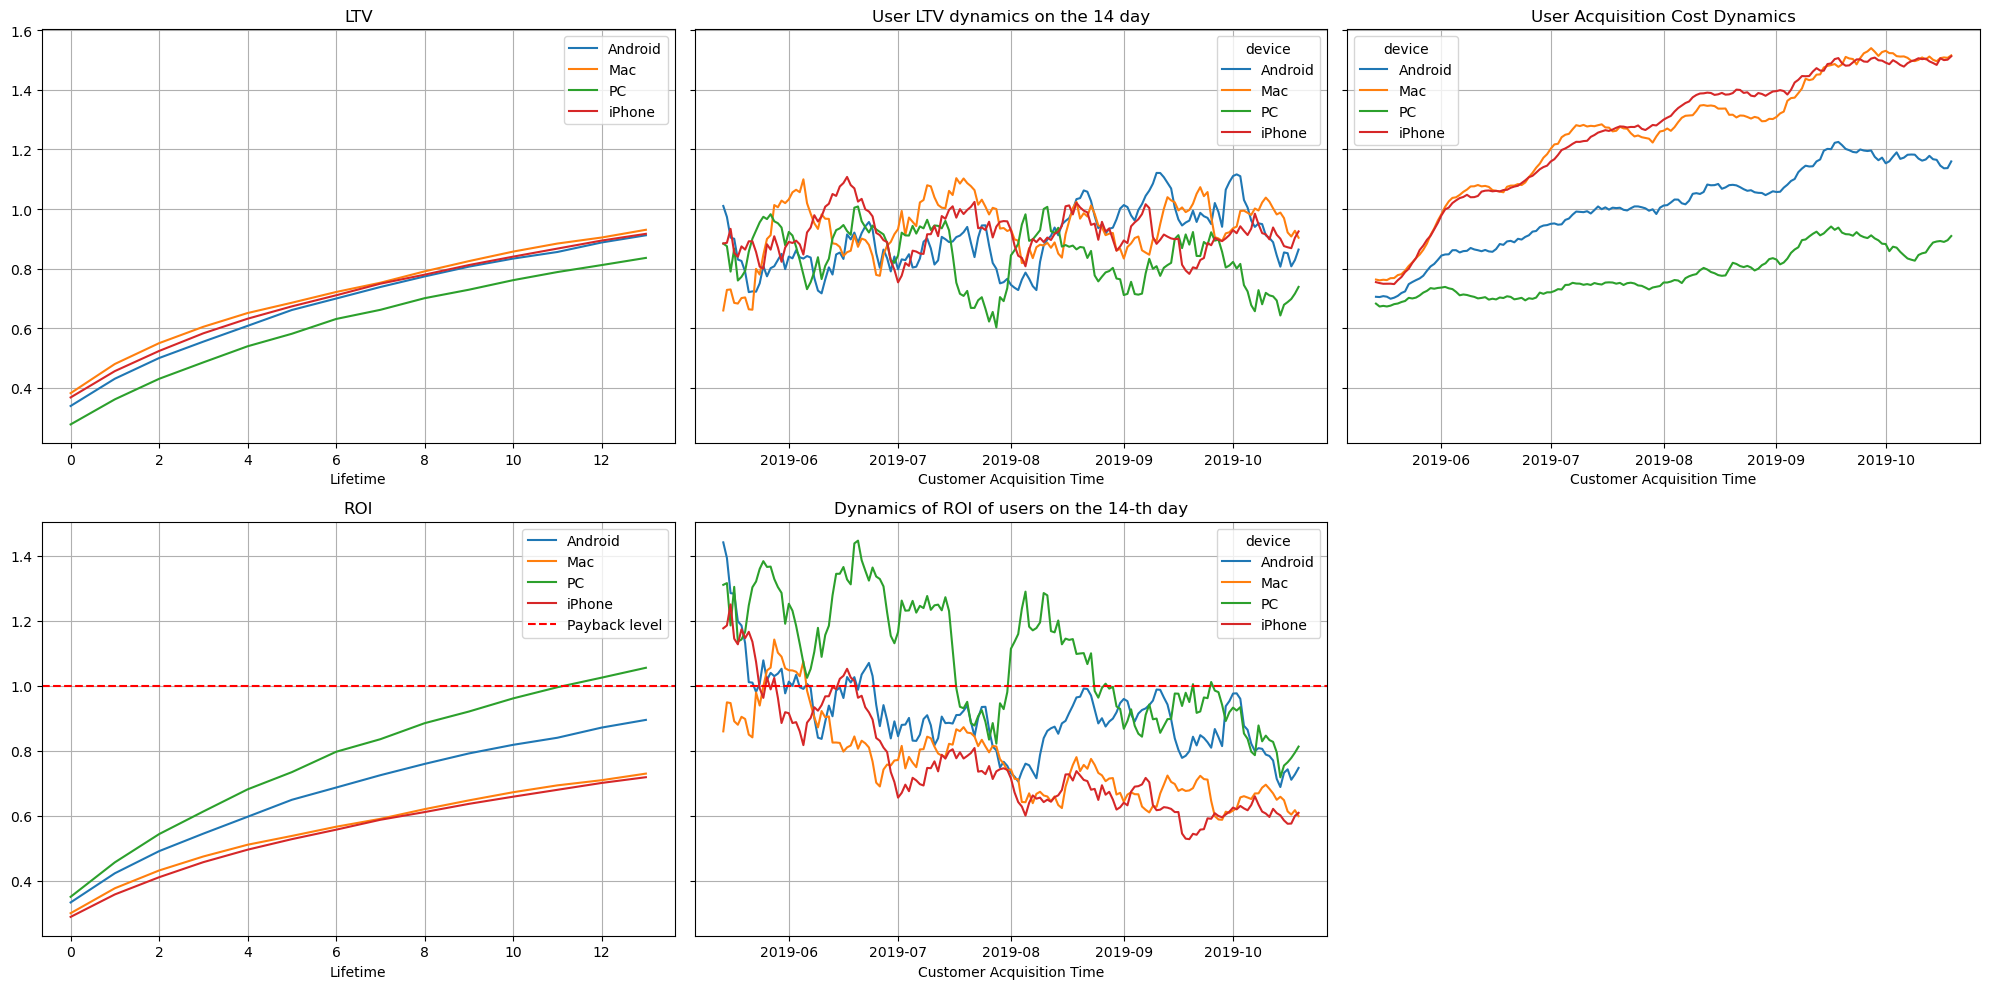

In [44]:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

`Notes`:
- LTV - PC users bring the least amount of money. All other devices practically merge by the end of day 14.
- Dynamics of LTV is insignificant in this case. But there are short periods in August, September and October when PC separates from the group and shows lower values.
- The cost of attraction has increased on all devices. Especially on IOS system.
- Despite the small size in terms of LTV, only PC overcomes the payback limit, however, by September, PC also falls below the payback bar. It is important that at the beginning of May Iphone and Android also paid off.

### Analysis of advertising ROI by country.

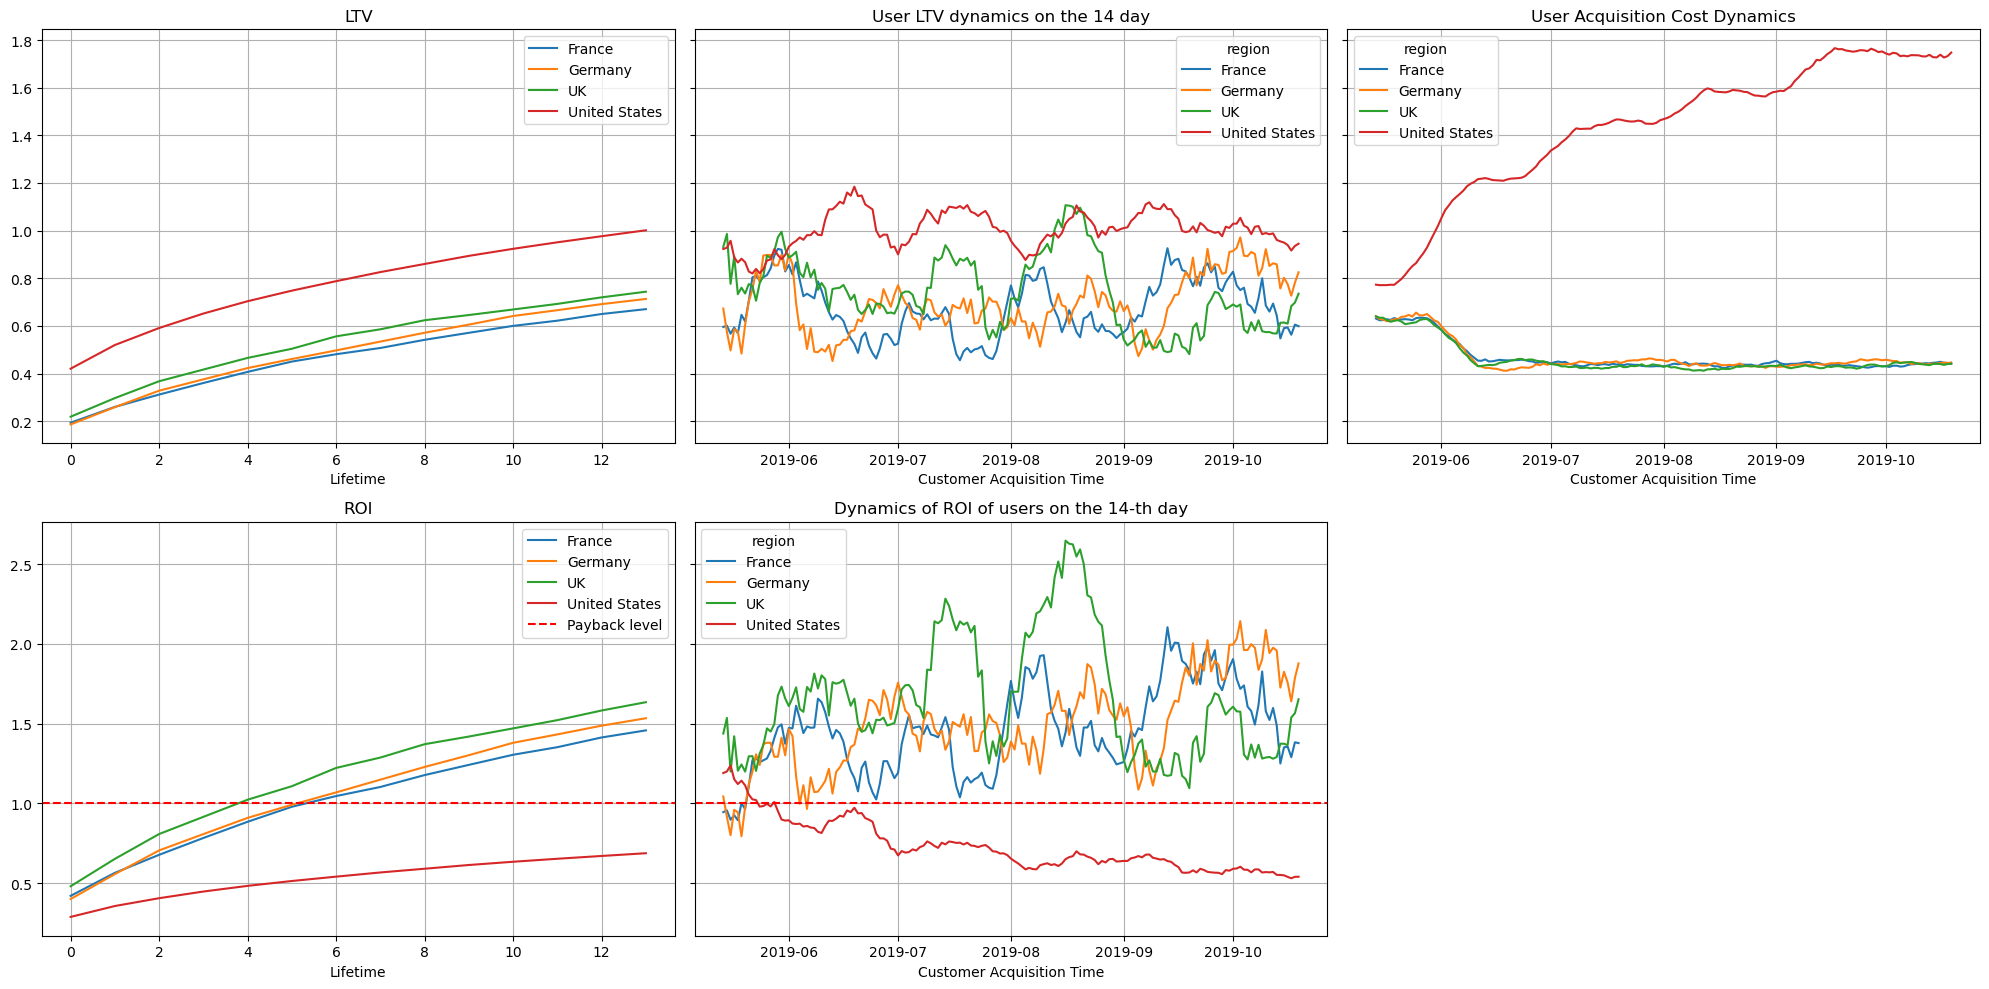

In [45]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

`Notes`:
- LTV shows that the US is the clear leader. Europe almost merges at the beginning of lifetime, but by the end it stratifies and England comes out on top. According to the graph of LTV dynamics, the picture is almost the same: the USA is the leader, but England catches up with the USA in August.
- US acquisition costs are showing wild growth. And Europe has been declining since June. The advertising budget is skewed towards America.
- ROI in Europe shows payback, but the US pulls everyone down.

### Analysis of advertising ROI broken down by advertising channels.

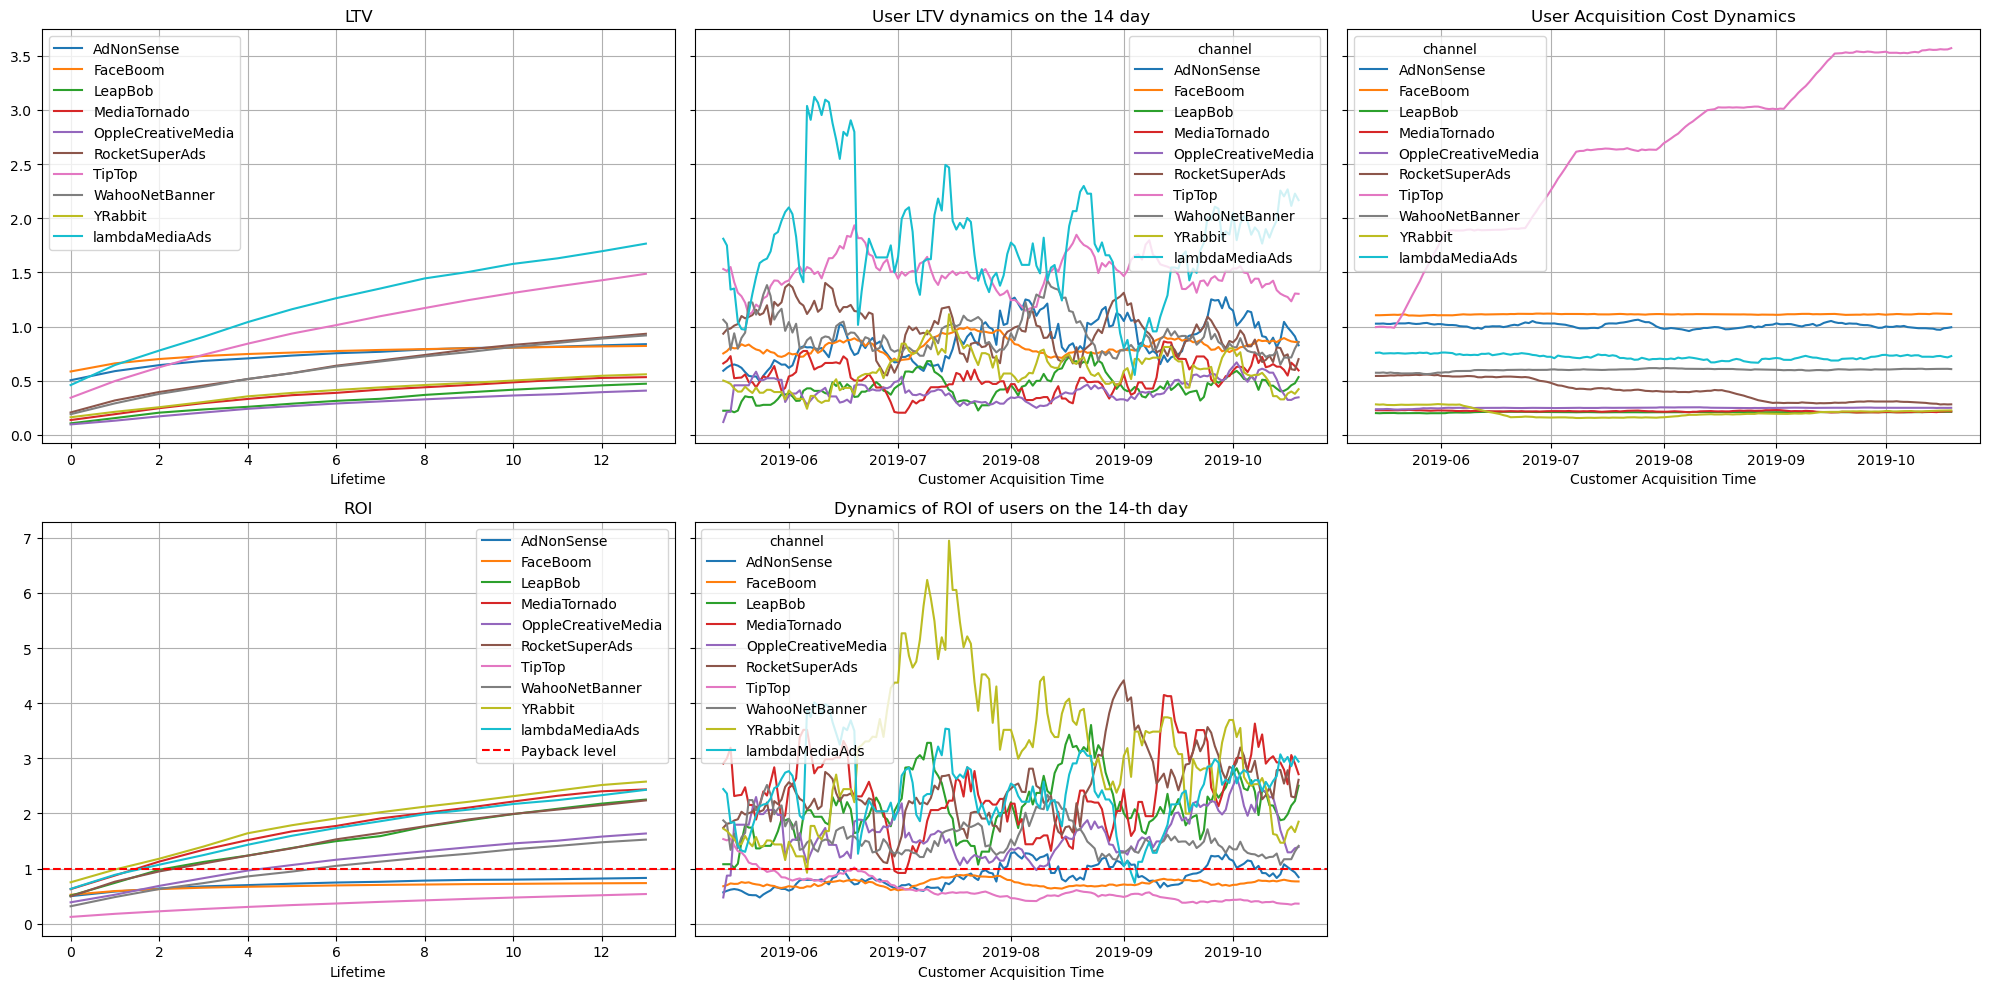

In [46]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

`Notes`:
- Favorable sources of money raised are TipTop and lambdaMediaAds.
- ROI shows that only three sources do not pay off, and since the cost of attracting TipTop has skyrocketed, this is pulling the company into losses. Advertising does not pay off at all due to the high cost of attraction.
- YRabbit stands out, it is the most profitable and in terms of ROI dynamics.

Let's unite the countries into regions: the USA and Europe.

In [47]:
usa_europe = profiles.copy()
usa_europe['region'] = usa_europe['region'].apply(lambda x: x if x == 'United States' else 'Europe')

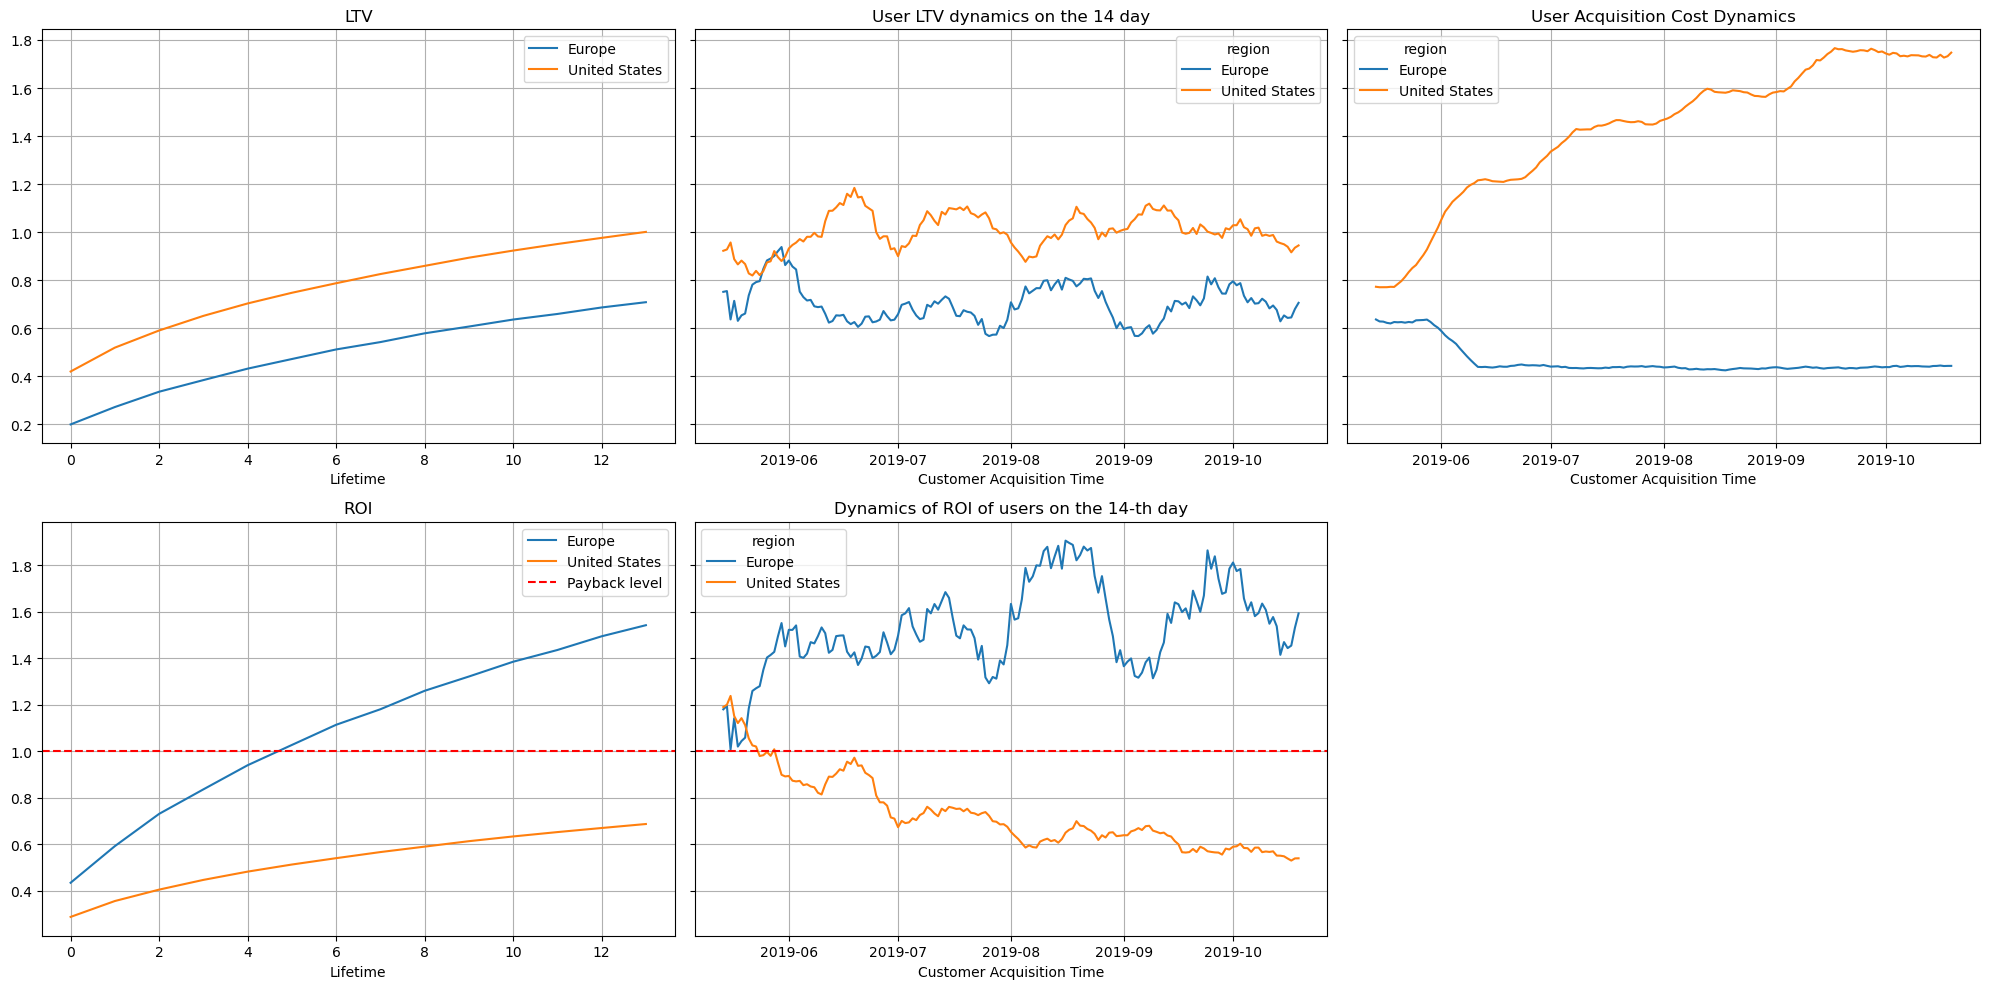

In [48]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    usa_europe, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

`Notes`:
- Europe is the undisputed leader in return on investment. Advertising in this segment pays off already on the 4th day of lifetime.
- The cost of attraction in Europe is lower than in the US and shows a downward trend.
- The US market is clearly overvalued and pulls the company into losses. It is obvious that companies can be invested in advertising on the European market in order to gain profit.

Let's see what the ROI of sources of attraction looks like in the context of macro-regions of the USA and Europe. So we will understand in which sources it will be safer and more profitable to invest advertising money.

In [49]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    usa_europe, orders, observation_date, horizon_days, dimensions=['channel', 'region']
)
roi_test_channel = roi_grouped.drop(columns=['cohort_size', 'cac'])
roi_test_channel.columns = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13']
roi_test_channel = roi_test_channel.drop(columns=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'])                        
roi_test_channel = roi_test_channel.pivot_table(index='channel', columns='region')

roi_test_channel.columns=['Europe', 'United States']
roi_test_channel.sort_values(by='United States', ascending=False)

,Europe,United States
channel,,
YRabbit,NaN,2.578086
MediaTornado,NaN,2.436519
RocketSuperAds,NaN,2.237019
FaceBoom,NaN,0.737790
TipTop,NaN,0.539532
AdNonSense,0.831337,NaN
LeapBob,2.252399,NaN
OppleCreativeMedia,1.637075,NaN
WahooNetBanner,1.526304,NaN


`Notes`:
Important! A source pays off if its ROI is greater than one. The table shows the value of 14 days ROI for each source.
- Only three out of ten sources did not reach payback on the 14th day of lifetime. At first glance, this is quite a normal phenomenon, if it were not for the exorbitant cost of attraction in these sources, we also recall that more than 80% of the advertising budget and more than 50% of all advertising campaigns are spent on them. It is for this reason that the entire US market shows low ROI.
- Three sources from the US show ROI above 2 and only two European sources with ROI above 2.

### Conclusion

- Due to the fact that 80% of the advertising budget comes from two sources, TipTop and Faceboom, and the cost of attracting these channels is too high and does not provide a return on investment, and the lion's share of the funds falls on the US region, whose ROI is significantly lower than the payback, all this brings the company losses. It is recommended to review the allocation of advertising budget funds to sources whose investments pay off. This will reduce the cost of attracting, which does not give the desired result. You should also strengthen the sources of attracting customers from the United States with a lower cost and a positive ROI.


- When deciding to completely abandon TipTop and Faceboom sources, you first need to check the settings for advertising in order to eliminate the factor of erroneous criteria in determining the target audience. If the target audience was determined correctly, then TipTop and Faceboom sources should be abandoned for a while (approximately 6 months). It is likely that there are target audiences in these sources, but they are very expensive for the company. In other words, the company cannot afford them at this stage of its development and the level of business stability.


- If we consider the European market, then pay attention to sources with a conversion above 3% and a positive ROI and invest in them with an even distribution between them. In addition, it is necessary to check why the largest category of users in the IOS segment (iPhone and MAC) do not pay off, probably there are reasons in the application settings or its interface.